ThinCurr Python Example: Compute time-domain with mode driver in a torus {#doc_tCurr_torus_td}
==========
In this example we demonstrate how to perform a time-domain simulation for a model driven by the plasma mode computed in \ref doc_tCurr_torus_mode.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) and [pyvista](https://pyvista.org/) python packages, which are installable using `pip` or other standard methods.

In [1]:
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyvista
pyvista.set_jupyter_backend('static') # Comment to enable interactive PyVista plots
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load ThinCurr library

To load the ThinCurr python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` for binaries on macOS).

In [2]:
thincurr_python_path = os.getenv('OFT_ROOTPATH')
if thincurr_python_path is not None:
    sys.path.append(os.path.join(thincurr_python_path,'python'))
from OpenFUSIONToolkit.ThinCurr import ThinCurr
from OpenFUSIONToolkit.ThinCurr.sensor import Mirnov, save_sensors
from OpenFUSIONToolkit.util import build_XDMF
from OpenFUSIONToolkit.io import histfile

## Compute frequency response

### Setup ThinCurr model
We now create a \ref OpenFUSIONToolkit.ThinCurr.ThinCurr "ThinCurr" instance to use for equilibrium calculations. As this is a larger model, we use `nthreads=4` to increase the number of cores used for the calculation. Once created, we setup the model from an existing HDF5 and XML mesh definition using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_model "setup_model()". We also initialize I/O for this model using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_io "setup_io()" to enable output of plotting files for 3D visualization in [VisIt](https://visit-dav.github.io/visit-website/index.html), [Paraview](https://www.paraview.org/), or using [pyvista](https://pyvista.org/) below.

In [3]:
tw_torus = ThinCurr(nthreads=4)
tw_torus.setup_model(mesh_file='thincurr_ex-torus.h5',xml_filename='oft_in.xml')
tw_torus.setup_io()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   thermal_diffusion_ex
Revision id:          48644a4
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    4
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


Creating thin-wall model
 Orientation depth =        3122
  Loading V(t) driver coils
  Loading I(t) driver coils

  # of points    =         2394
  # of edges     =         7182
  # of cells     =         4788
  # of holes     =            2
  # of Vcoils    =            0
  # of closures  =            1
  # of Icoils    =            1

  Building holes

  Loading region res

### Create sensor file
Before running the main calculations we will also define some sensors to measure the magnetic field. In ThinCurr all sensors measure the flux passing through a 3D path of points, but there are several helper classes to define common sensors (eg. \ref OpenFUSIONToolkit.ThinCurr.sensor.circular_flux_loop "Poloidal flux" and \ref OpenFUSIONToolkit.ThinCurr.sensor.Mirnov "Mirnovs"). Here we define two Mirnov sensors to measure the Z-component of the magnetic field 5 cm on either side of the torus. \ref OpenFUSIONToolkit.ThinCurr.sensor.save_sensors "save_sensors()" is then used to save the resulting sensor for later use.

In [4]:
sensors = [
    Mirnov([1.45,0.0,0.0], [0.0,0.0,1.0], 'Bz_inner'),
    Mirnov([1.55,0.0,0.0], [0.0,0.0,1.0], 'Bz_outer'),
    Mirnov([1.45,0.0,0.0], [1.0,0.0,0.0], 'Br_inner'),
    Mirnov([1.55,0.0,0.0], [1.0,0.0,0.0], 'Br_outer'),
]
save_sensors(sensors)
Msensor, Msc, sensor_obj = tw_torus.compute_Msensor('floops.loc')


 Loading floop information:
   # of floops =           4
 Building element->sensor inductance matrix
 Building coil->sensor inductance matrix


### Compute self-inductance and resistivity matrices
With the model setup, we can now compute the self-inductance and resistivity matrices. A numpy version of the self-inductance matrix will be stored at \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.Lmat "tw_plate.Lmat". By default the resistivity matrix is not moved to python as it is sparse and converting to dense representation would require an increase in memory. These matrices correspond to the $\textrm{L}$ and $\textrm{R}$ matrices for the physical system

$\textrm{L} \frac{\partial I}{\partial t} + \textrm{R} I = V$

**Note:** For larger models calculating the self-inductance may take some time due to the $N^2$ interaction of the elements (see \ref doc_thincurr_ex4 for more information).

In [5]:
Mc = tw_torus.compute_Mcoil()
tw_torus.compute_Lmat()
tw_torus.compute_Rmat()

 Building coil<->element inductance matrices
     Time =  0s          
 Building coil<->coil inductance matrix
 Building element<->element self inductance matrix
     Time =  5s          
 Building resistivity matrix


## Setup plasma mode driver model


In [6]:
tw_mode = ThinCurr(nthreads=4)
tw_mode.setup_model(mesh_file='thincurr_mode.h5')
with h5py.File('thincurr_mode.h5', 'r+') as h5_file:
    mode_drive = np.asarray(h5_file['thincurr/driver'])


Creating thin-wall model
 Orientation depth =       12640
  Loading V(t) driver coils
  Loading I(t) driver coils

  # of points    =         6320
  # of edges     =        18960
  # of cells     =        12640
  # of holes     =            3
  # of Vcoils    =            0
  # of closures  =            2
  # of Icoils    =            0

  Building holes


## Compute coupling from plasma mode to torus model

In [7]:
Msensor_plasma, _, _ = tw_mode.compute_Msensor('floops.loc')
mode_driver = tw_mode.cross_eval(tw_torus,mode_drive)
sensor_mode = np.dot(mode_drive,Msensor_plasma)


 Loading floop information:
   # of floops =           4
 Building element->sensor inductance matrix
 Building coil->sensor inductance matrix
 Applying MF element<->element inductance matrix
     Time = 24s          


## Compute frequency-response to plasma modes

In [8]:
mode_freq = 1.E3
mode_growth = 2.E3
dt = (1.0/1.E3)/50.0
nsteps = 200
timebase_current = np.arange(0.0,dt*nsteps+1,dt/4.0); timebase_voltage = (timebase_current[1:]+timebase_current[:-1])/2.0
cos_current = timebase_current/mode_growth*np.cos(mode_freq*2.0*np.pi*timebase_current); cos_voltage = np.diff(cos_current)/np.diff(timebase_current)
sin_current = timebase_current/mode_growth*np.sin(mode_freq*2.0*np.pi*timebase_current); sin_voltage = np.diff(sin_current)/np.diff(timebase_current)
volt_full = np.zeros((nsteps+2,tw_torus.nelems+1))
sensor_signals = np.zeros((nsteps+2,sensor_mode.shape[1]+1))
for i in range(nsteps+2):
    volt_full[i,0] = dt*i
    sensor_signals[i,0] = dt*i
    if i > 0:
        volt_full[i,1:] = mode_driver[0,:]*np.interp(volt_full[i,0],timebase_voltage,cos_voltage) \
          + mode_driver[1,:]*np.interp(volt_full[i,0],timebase_voltage,sin_voltage)
        sensor_signals[i,1:] = sensor_mode[0,:]*np.interp(volt_full[i,0],timebase_current,cos_current) \
          + sensor_mode[1,:]*np.interp(volt_full[i,0],timebase_current,sin_current)
tw_torus.run_td(dt,nsteps,status_freq=10,full_volts=volt_full,sensor_obj=sensor_obj,direct=True,sensor_values=sensor_signals)


 Starting simulation
 Starting factorization
 Inverting real matrix
   Time =   0.31028600000000001     
 Timestep           10   1.99999995E-04   3.99827229E-07           1
 Timestep           20   3.99999990E-04   5.56573525E-07           1
 Timestep           30   6.00000028E-04   1.00404748E-06           1
 Timestep           40   7.99999980E-04   1.52440816E-06           1
 Timestep           50   1.00000005E-03   1.17628156E-06           1
 Timestep           60   1.20000006E-03   2.44649073E-06           1
 Timestep           70   1.39999995E-03   1.94968584E-06           1
 Timestep           80   1.59999996E-03   2.67586893E-06           1
 Timestep           90   1.79999997E-03   3.43731426E-06           1
 Timestep          100   2.00000009E-03   2.36427718E-06           1
 Timestep          110   2.19999999E-03   4.49318622E-06           1
 Timestep          120   2.40000011E-03   3.34289325E-06           1
 Timestep          130   2.60000001E-03   4.34776484E-06          


OFT History file: floops.hist
  Number of fields = 5
  Number of entries = 201

  Fields:
    time: Simulation time [s] (d1)
    Bz_inner: No description (d1)
    Bz_outer: No description (d1)
    Br_inner: No description (d1)
    Br_outer: No description (d1)



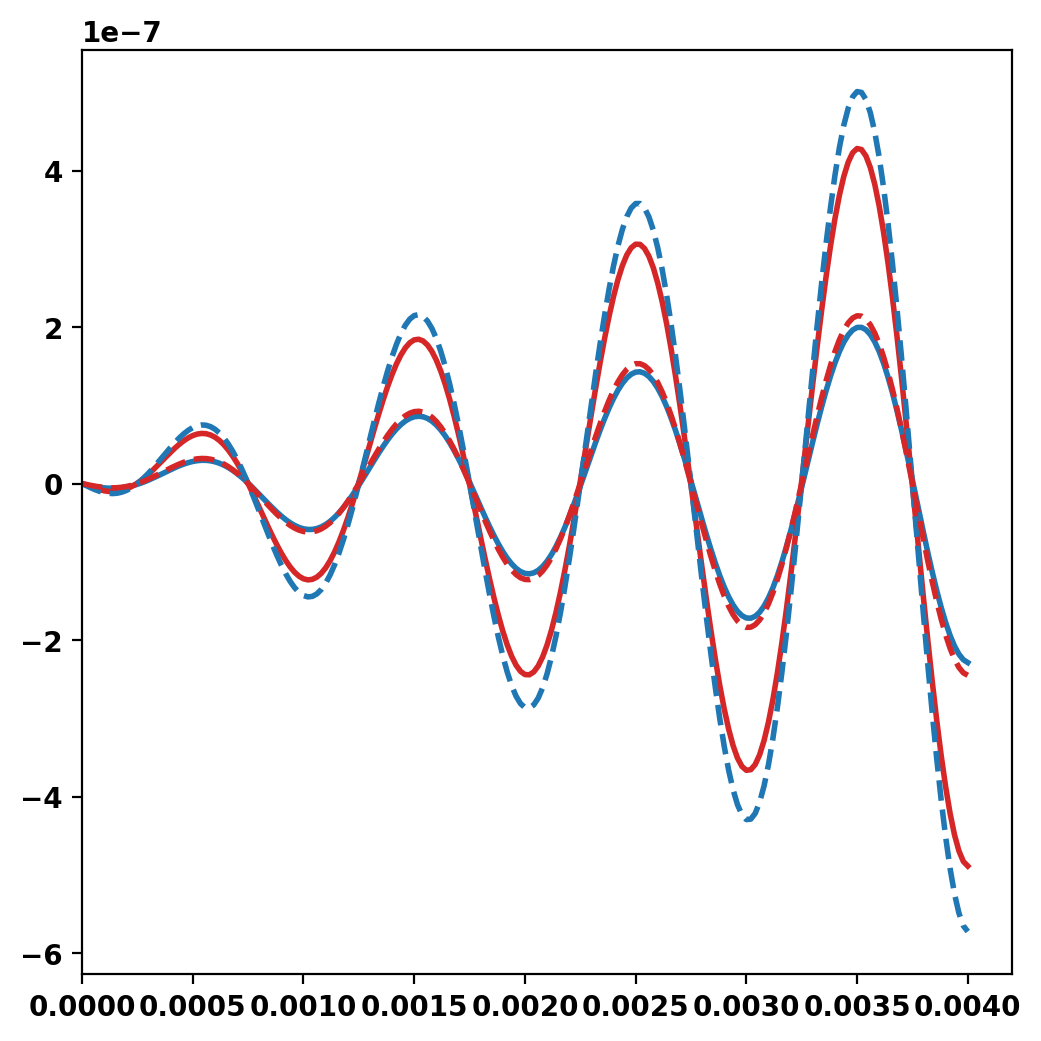

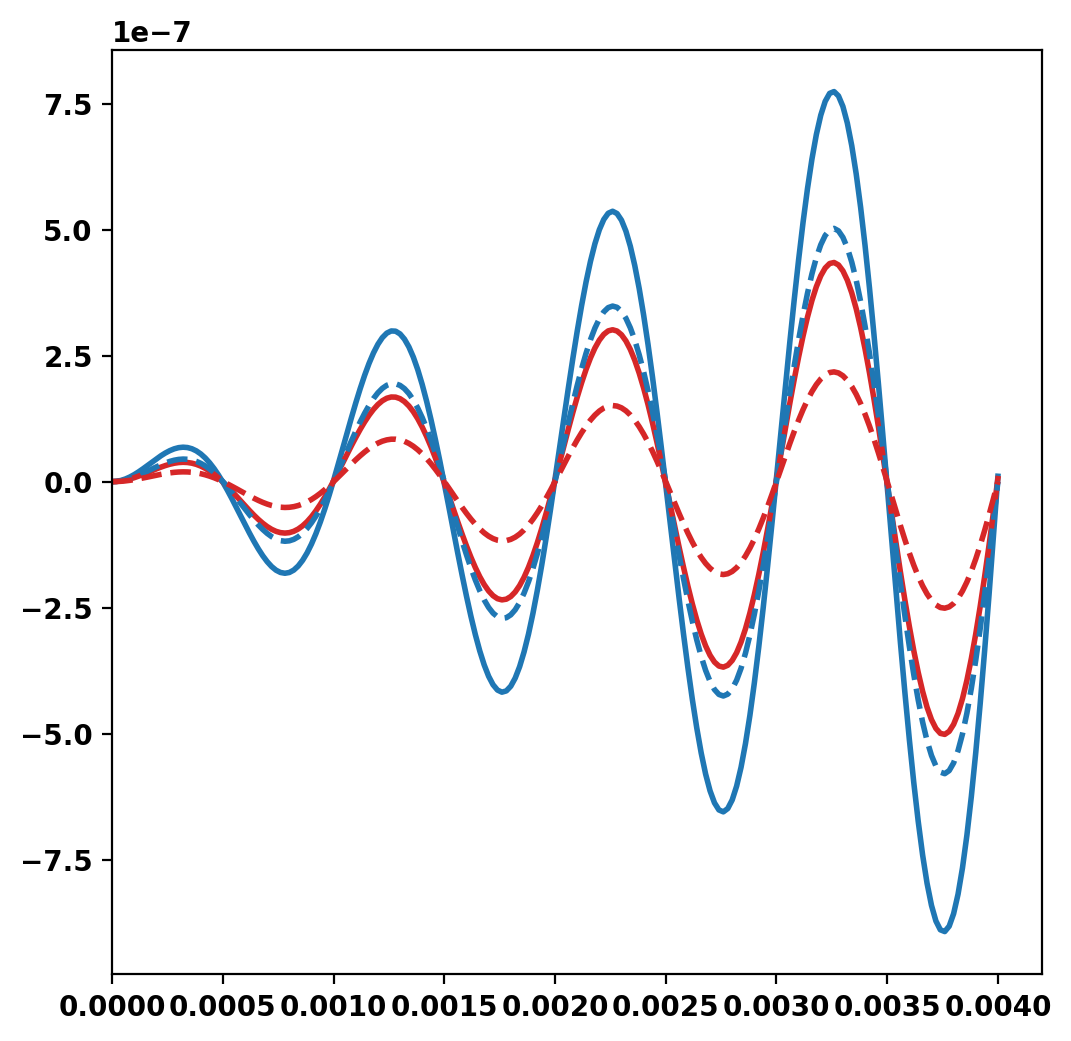

In [9]:
hist_file = histfile('floops.hist')
print(hist_file)

fig, ax = plt.subplots(1,1)
ax.plot(hist_file['time'],hist_file['Bz_inner'],color='tab:blue')
ax.plot(hist_file['time'],hist_file['Bz_outer'],color='tab:red')
ax.plot(hist_file['time'],sensor_signals[:-1,1],'--',color='tab:blue')
ax.plot(hist_file['time'],sensor_signals[:-1,2],'--',color='tab:red')
_ = ax.set_xlim(left=0.0)

fig, ax = plt.subplots(1,1)
ax.plot(hist_file['time'],hist_file['Br_inner'],color='tab:blue')
ax.plot(hist_file['time'],hist_file['Br_outer'],color='tab:red')
ax.plot(hist_file['time'],sensor_signals[:-1,3],'--',color='tab:blue')
ax.plot(hist_file['time'],sensor_signals[:-1,4],'--',color='tab:red')
_ = ax.set_xlim(left=0.0)

## Compute sensor mutual inductance matrices

In [10]:
tw_torus.plot_td(nsteps,sensor_obj=sensor_obj)
tw_torus.build_XDMF()

 Post-processing simulation
Removing old Xdmf files
Creating output files


# Plot current fields

## Load data from plot files

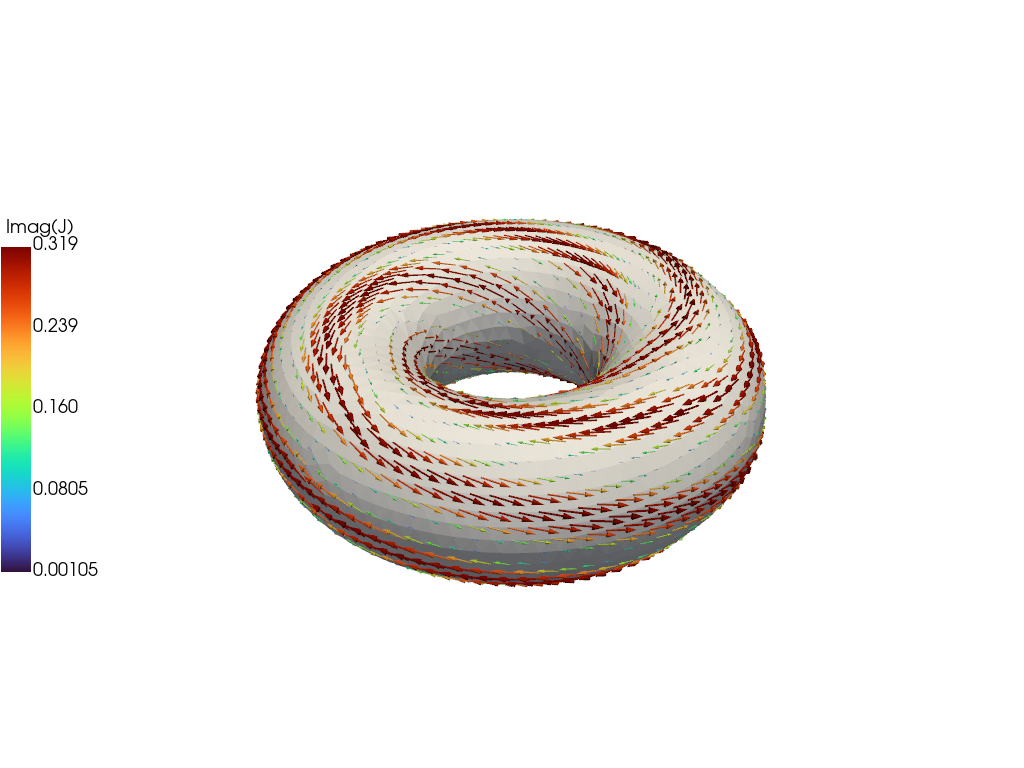

In [12]:
# Load mesh and current from plot files
with h5py.File('mesh.0001.h5','r') as h5_file:
    r = np.asarray(h5_file['R_surf'])
    lc = np.asarray(h5_file['LC_surf'])
with h5py.File('vector_dump.0001.h5','r') as h5_file:
    J = np.asarray(h5_file['J_v0011'])

# Create pyvista mesh for plotting
celltypes = np.array([pyvista.CellType.TRIANGLE for _ in range(lc.shape[0])], dtype=np.int8)
cells = np.insert(lc, [0,], 3, axis=1)
grid = pyvista.UnstructuredGrid(cells, celltypes, r)

# Plot mesh and current density using PyVista
p = pyvista.Plotter()
grid["vectors"] = J
grid.set_active_vectors("vectors")
scale = 0.2/(np.linalg.norm(J,axis=1)).max()
arrows = grid.glyph(scale="vectors", orient="vectors", factor=scale)
p.add_mesh(arrows, cmap="turbo", scalar_bar_args={'title': "Imag(J)", "vertical": True, "position_y":0.25, "position_x": 0.0})
p.add_mesh(grid, color="white", opacity=1.0, show_edges=False)
p.show()